In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import copy

In [3]:
class SampleNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.input_layer = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3) # 28*28*1 -> 26*26*4
        self.pooling = nn.MaxPool2d(kernel_size=2) 
        self.activation = nn.ReLU()
        self.conv = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=11*11*16, out_features=512)
        self.dropout = nn.Dropout(0.2)
        self.output = nn.Linear(in_features=512, out_features=10)
    
    def forward(self, x):
        x = self.pooling(self.activation(self.input_layer(x))) # 28 * 28 * 1 -> 26 * 26 * 4 -> 13 * 13 * 4
        x = self.activation(self.conv(x)) # 13 * 13 * 4 -> 11 * 11 * 16
        return self.output(self.dropout(self.linear(self.flatten(x)))) # 11 * 11 * 16 -> 512 -> 10
        

In [70]:
global_model = SampleNet()
num_rounds = 40
num_clients = 3

In [71]:
transform = transforms.ToTensor()
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

client_data_indices = [[] for _ in range(num_clients)]


In [72]:
data_mappings = {int(x): [] for x in np.unique(mnist_data.targets)}
for idx, target in enumerate(mnist_data.targets):
    data_mappings[int(target.item())].append(idx)

In [73]:
target_to_client = {
    0: 0,
    1: 0,
    2: 0,
    3: 1,
    4: 1,
    5: 1,
    6: 1,
    7: 2,
    8: 2,
    9: 2
}

for tgt in data_mappings.keys():
    client_data_indices[target_to_client[tgt]].extend(data_mappings[tgt])

In [74]:
client_loaders = [DataLoader(Subset(mnist_data, idx), batch_size=32, shuffle=True) for idx in client_data_indices]
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [75]:
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
    accuracy = 100 * correct / total
    return accuracy

def client_update(model, train_loader, epochs=1, lr=0.01):
    model = copy.deepcopy(model)
    model.train()
    
    optimizer = optim.SGD(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    
    for _ in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

    return model.state_dict()


In [76]:
def average_weights(w_list):
    avg_w = copy.deepcopy(w_list[0])
    for key in avg_w.keys():
        for i in range(1, len(w_list)):
            avg_w[key] += w_list[i][key]
        avg_w[key] = torch.div(avg_w[key], len(w_list))
    return avg_w


In [77]:
accuracies_avg = []
for round in range(num_rounds):
    print(f"\n--- Round {round+1} ---")
    local_weights = []

    for client_id in range(num_clients):
        client_model = copy.deepcopy(global_model)
        local_w = client_update(client_model, client_loaders[client_id], epochs=1)
        local_weights.append(local_w)

    global_weights = average_weights(local_weights)
    global_model.load_state_dict(global_weights)

    acc = evaluate_model(global_model, test_loader)
    accuracies_avg.append(acc)
    print(f"Global Test Accuracy: {acc:.2f}%")


--- Round 1 ---
Global Test Accuracy: 62.28%

--- Round 2 ---
Global Test Accuracy: 76.31%

--- Round 3 ---
Global Test Accuracy: 76.38%

--- Round 4 ---
Global Test Accuracy: 79.94%

--- Round 5 ---
Global Test Accuracy: 80.51%

--- Round 6 ---
Global Test Accuracy: 81.33%

--- Round 7 ---
Global Test Accuracy: 82.56%

--- Round 8 ---
Global Test Accuracy: 84.75%

--- Round 9 ---
Global Test Accuracy: 86.03%

--- Round 10 ---
Global Test Accuracy: 86.75%

--- Round 11 ---
Global Test Accuracy: 88.09%

--- Round 12 ---
Global Test Accuracy: 89.57%

--- Round 13 ---
Global Test Accuracy: 89.78%

--- Round 14 ---
Global Test Accuracy: 91.11%

--- Round 15 ---
Global Test Accuracy: 91.53%

--- Round 16 ---
Global Test Accuracy: 92.39%

--- Round 17 ---
Global Test Accuracy: 92.63%

--- Round 18 ---
Global Test Accuracy: 92.75%

--- Round 19 ---
Global Test Accuracy: 93.23%

--- Round 20 ---
Global Test Accuracy: 93.31%

--- Round 21 ---
Global Test Accuracy: 93.67%

--- Round 22 ---
Glob

In [78]:
global_model = SampleNet()
prox_acc = []
num_rounds = 40
num_clients = 3

In [79]:
def fedprox_update(local_model, global_model, loader, mu=0.01, lr=0.01, epochs=1):
    model = copy.deepcopy(local_model)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    global_weights_vector = torch.cat([param.flatten() for param in global_model.parameters()])
    
    for _ in range(epochs):
        for data, target in loader:
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            
            prox_reg = 0
            local_weights_vector = torch.cat([param.flatten() for param in model.parameters()])
            prox_reg = torch.norm(local_weights_vector - global_weights_vector) ** 2
            loss += mu * prox_reg
    
            loss.backward()
            optimizer.step()
    return model.state_dict()


In [80]:
for round in range(num_rounds):
    print(f"\n--- Round {round+1} ---")
    local_weights = []

    for client_id in range(num_clients):
        client_model = copy.deepcopy(global_model)
        local_w = fedprox_update(client_model, global_model, client_loaders[client_id])
        local_weights.append(local_w)

    if local_weights:
        global_weights = average_weights(local_weights)
        global_model.load_state_dict(global_weights)

    acc = evaluate_model(global_model, test_loader)
    prox_acc.append(acc)
    print(f"Global Test Accuracy: {acc:.2f}%")


--- Round 1 ---
Global Test Accuracy: 58.77%

--- Round 2 ---
Global Test Accuracy: 74.13%

--- Round 3 ---
Global Test Accuracy: 77.49%

--- Round 4 ---
Global Test Accuracy: 78.38%

--- Round 5 ---
Global Test Accuracy: 79.70%

--- Round 6 ---
Global Test Accuracy: 80.12%

--- Round 7 ---
Global Test Accuracy: 81.36%

--- Round 8 ---
Global Test Accuracy: 81.42%

--- Round 9 ---
Global Test Accuracy: 82.64%

--- Round 10 ---
Global Test Accuracy: 84.64%

--- Round 11 ---
Global Test Accuracy: 86.26%

--- Round 12 ---
Global Test Accuracy: 85.63%

--- Round 13 ---
Global Test Accuracy: 88.24%

--- Round 14 ---
Global Test Accuracy: 89.15%

--- Round 15 ---
Global Test Accuracy: 89.41%

--- Round 16 ---
Global Test Accuracy: 90.53%

--- Round 17 ---
Global Test Accuracy: 91.04%

--- Round 18 ---
Global Test Accuracy: 92.04%

--- Round 19 ---
Global Test Accuracy: 92.66%

--- Round 20 ---
Global Test Accuracy: 92.66%

--- Round 21 ---
Global Test Accuracy: 92.63%

--- Round 22 ---
Glob

In [81]:
import matplotlib.pyplot as plt

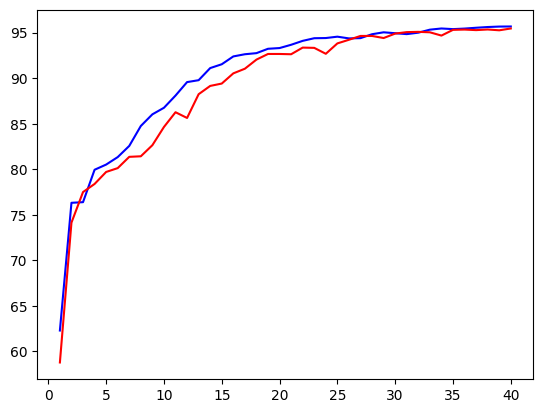

In [83]:
plt.plot(np.arange(1, 41, 1), accuracies_avg, 'b')
plt.plot(np.arange(1, 41, 1), prox_acc, 'r')